In [4]:
%config Completer.use_jedi = False

In [261]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import decomposition
from sklearn import cluster
import pandas as pd
import json
import flask
from contrastive import CPCA
import seaborn as sns

In [262]:
painting_urls = json.load(open('painting_image_urls.json', 'r'))
episodes      = json.load(open('episode_names.json', 'r'))
attributes    = json.load(open('attribute_names.json', 'r'))
data = np.load('painting_attributes.npy')

### PCA usando SVD

In [354]:
# pd.DataFrame(dict(zip(attributes,proj)))
pd.DataFrame(zip(attributes,pca_components[0]),columns=['attribute','loading']).to_json(orient='records')

'[{"attribute":"WAVES","loading":-0.1134757996},{"attribute":"OCEAN","loading":-0.1197568923},{"attribute":"WATERFALL","loading":-0.0330406725},{"attribute":"SUN","loading":-0.0722718835},{"attribute":"PATH","loading":-0.0746561736},{"attribute":"WINTER","loading":0.1348591298},{"attribute":"CABIN","loading":0.0495000519},{"attribute":"SNOW","loading":0.1330330968},{"attribute":"ROCKS","loading":-0.1304750144},{"attribute":"CUMULUS","loading":0.0882770792},{"attribute":"SNOWY_MOUNTAIN","loading":0.4396289289},{"attribute":"BUSHES","loading":0.1526136547},{"attribute":"RIVER","loading":-0.1093590856},{"attribute":"GRASS","loading":-0.0964601189},{"attribute":"LAKE","loading":0.2782639265},{"attribute":"MOUNTAIN","loading":0.5058717132},{"attribute":"CLOUDS","loading":0.1214413047},{"attribute":"CONIFER","loading":0.4821279347},{"attribute":"DECIDUOUS","loading":-0.2509753108},{"attribute":"TREE","loading":0.1280312389}]'

In [263]:
data_centered = data.copy() 
data_centered -= np.mean(data_centered, axis=0) 
U, s, VT = np.linalg.svd(data_centered)
pca_components = VT[:2,:].astype(float)

In [288]:
C = np.cov(data_centered.T)
w,v = np.linalg.eig(C)
eig_idx = np.argpartition(w, -2)[-2:]
eig_idx = eig_idx[np.argsort(-w[eig_idx])]
pc = v[:,eig_idx]

In [328]:
pc[:,0]

array([-0.1134758 , -0.11975689, -0.03304067, -0.07227189, -0.07465617,
        0.13485913,  0.04950005,  0.1330331 , -0.13047501,  0.08827708,
        0.43962893,  0.15261365, -0.10935909, -0.09646012,  0.27826393,
        0.50587173,  0.12144131,  0.48212794, -0.25097531,  0.12803124])

In [289]:
# pc.T @ data_centered[:,:]
proj_data = []
for row in data_centered:
    proj_data.append(pc.T @ row)
proj_data = np.array(proj_data).copy()

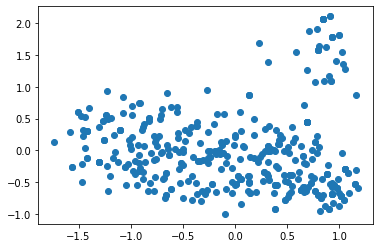

In [290]:
plt.plot(-proj_data[:,0],-proj_data[:,1],'o')

In [291]:
x_loadings = dict(zip(attributes,pca_components[0]))
y_loadings = dict(zip(attributes,pca_components[1]))

In [292]:
json.dumps([x_loadings,y_loadings])
# myDict = {'a':['apple', 'avacado'], 'b':['banana', 'berry'], 'vitamins':2.0142}
# jsonStr = json.dumps(myDict)

'[{"WAVES": -0.11347579956054688, "OCEAN": -0.11975689232349396, "WATERFALL": -0.03304067254066467, "SUN": -0.07227188348770142, "PATH": -0.0746561735868454, "WINTER": 0.1348591297864914, "CABIN": 0.04950005188584328, "SNOW": 0.13303309679031372, "ROCKS": -0.1304750144481659, "CUMULUS": 0.08827707916498184, "SNOWY_MOUNTAIN": 0.439628928899765, "BUSHES": 0.15261365473270416, "RIVER": -0.10935908555984497, "GRASS": -0.09646011888980865, "LAKE": 0.2782639265060425, "MOUNTAIN": 0.5058717131614685, "CLOUDS": 0.1214413046836853, "CONIFER": 0.48212793469429016, "DECIDUOUS": -0.2509753108024597, "TREE": 0.12803123891353607}, {"WAVES": -0.31462517380714417, "OCEAN": -0.32782015204429626, "WATERFALL": 0.060872260481119156, "SUN": -0.04614000767469406, "PATH": 0.06328986585140228, "WINTER": 0.04509163647890091, "CABIN": 0.08909925818443298, "SNOW": 0.04129979386925697, "ROCKS": -0.1933104395866394, "CUMULUS": -0.2883758246898651, "SNOWY_MOUNTAIN": -0.003002157201990485, "BUSHES": 0.15087215602397

### K-Means

In [293]:
kmeans = cluster.KMeans(6)
kmeans.fit(proj_data)

KMeans(n_clusters=6)

In [294]:
df = pd.DataFrame(data,columns=attributes)
df["id"] = df.index
df['label'] = kmeans.labels_
df = df.melt(id_vars=['id','label']).sort_values(by='id')

In [295]:
proj = pd.DataFrame(proj_data,columns=['x','y'])
proj['label'] = kmeans.labels_

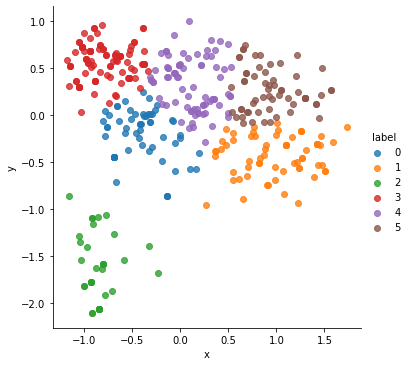

In [296]:
sns.lmplot(x='x',y='y', data=proj, hue='label', fit_reg=False)

In [297]:
# df.to_json(orient='records')
t = df.to_dict(orient='records')

### ccPCA

In [332]:
alpha = 3.1
# np.cov(df[df.label != 0][['x','y']].values)
l_i = np.array(proj[proj.label!=0].index)

In [335]:
len(proj)

403

In [309]:
cluster_y = data_centered[l_i,:]
cluster_y -= np.mean(cluster_y, axis=0) 
Cy = np.cov(cluster_y.T)
Cr = C - alpha*Cy
w,v = np.linalg.eig(Cr)
pcr = v[:,0:2]

In [310]:
eig_idx = np.argpartition(w, -2)[-2:]
eig_idx = eig_idx[np.argsort(-w[eig_idx])]
pcr = v[:,eig_idx]

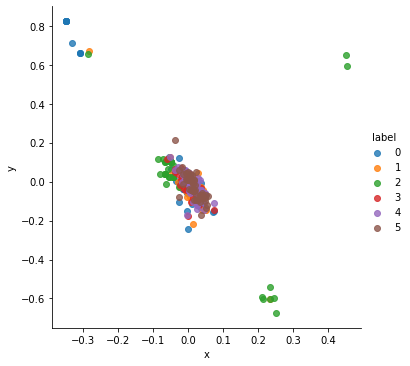

In [311]:
proj_data = []
for row in data_centered:
    proj_data.append(pcr.T @ row)
proj_data = np.array(proj_data).copy()
proj = pd.DataFrame(proj_data,columns=['x','y'])
proj['label'] = kmeans.labels_
sns.lmplot(x='x',y='y', data=proj, hue='label', fit_reg=False)

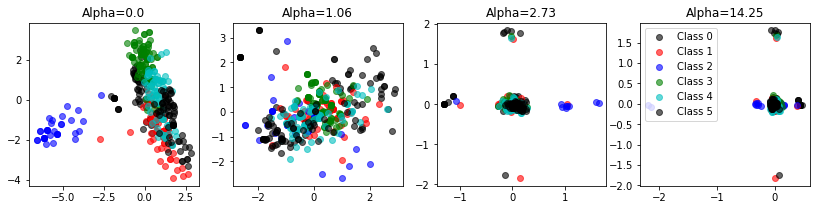

In [312]:
cpca = CPCA()
cpca.fit_transform(data_centered, cluster_y, plot=True, active_labels=kmeans.labels_)

In [249]:
cluster_y

array([[-0.09883718, -0.10465106, -0.09883725, ..., -0.5610466 ,
         0.4418604 ,  0.0901162 ],
       [-0.09883718, -0.10465106, -0.09883725, ...,  0.4389534 ,
        -0.5581396 ,  0.0901162 ],
       [-0.09883718, -0.10465106, -0.09883725, ...,  0.4389534 ,
        -0.5581396 ,  0.0901162 ],
       ...,
       [-0.09883718, -0.10465106, -0.09883725, ...,  0.4389534 ,
         0.4418604 ,  0.0901162 ],
       [-0.09883718, -0.10465106, -0.09883725, ...,  0.4389534 ,
         0.4418604 ,  0.0901162 ],
       [-0.09883718, -0.10465106, -0.09883725, ..., -0.5610466 ,
         0.4418604 ,  0.0901162 ]], dtype=float32)